In [188]:
import math
import glob
import numpy as np
from PIL import Image


# parameters

datadir = './data'
resultdir='./results'

# edgedetection
sigma=0.7
Gaussian_size= (3,3)
highThreshold=0.3 #max에서 몇퍼센트
lowThreshold=0.5 #highThreshold에서 몇퍼센트

#houghline
rhoRes=5
thetaRes=2 #math.pi/180*20
nLines=20


def replic_pad(Igs,size):
    H,W = Igs.shape
    h,w = size 
    h2,w2 = h//2, w//2
    padded = np.zeros((H+2*h2,W+2*w2))
    padded[h2:H+h2,w2:W+w2] = Igs[:,:].copy()
    
    for i in range(0,h2):
        padded[i,:] = padded[h2,:]
        padded[H+2*h2-1-i,:] = padded[H+h2-1,:]

    for j in range(0,w2):
        padded[:,j] = padded[:,w2].copy()
        padded[:,W+2*w2-1-j] = padded[:,W+w2-1]       
    return padded  
    

def ConvFilter(Igs, G):
    for s in G.shape:
        if s % 2 == 0:
            raise Exception("Kernel size must be odd")
    
    h, w = G.shape 
    h2, w2 = h//2, w//2
    padded = replic_pad(Igs.copy(), G.shape)
    H, W = padded.shape 
        
    #flip kernel
    for i in range(h2):
        G[i,:], G[2*h2-i,:] = G[2*h2-i,:].copy(), G[i,:].copy()
    for j in range(w2):
        G[:,j], G[:,2*w2-j] = G[:,2*w2-j].copy(), G[:,j].copy()
       
    #convolve
    Iconv = np.zeros(Igs.shape)   
    for i in range(h2,H-h2):
        for j in range(w2,W-w2):
            sum = 0
            for k in range(h):
                for l in range(w):
                    sum += padded[i-h2+k,j-w2+l]*G[k,l]
            Iconv[i-h2,j-w2] = sum
    
    return Iconv

def GaussianFilter(Igs,sigma,size):
    
    h,w = size
    h2,w2 = h//2, w//2
    
    col = np.zeros((h,1))
    row = np.zeros((1,w))
    colsum, rowsum = 0, 0
    col1 = math.exp(-math.pow(-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    row1 = math.exp(-math.pow(-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
   
    for i in range(h):
        col[i,:] = math.exp(-math.pow(i-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        col[i,:] = np.round(col[i,:]/col1)
        colsum += col[i,:]       
    for j in range(w):
        row[:,j] = math.exp(-math.pow(j-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        row[:,j] = np.round(row[:,j]/row1) 
        rowsum += row[:,j]

    gaussian = np.zeros(Igs.shape)
    gaussian = ConvFilter(ConvFilter(Igs.copy(),col),row)

    return gaussian/(rowsum*colsum)

def NMS(Im,Io):
    
    H,W = Im.shape
    nms = Im.copy()
       
    for i in range(0,H):
        for j in range(0,W):
            if (i !=0 and j !=0 and i != H-1 and j != W-1):
                if (Io[i,j] < 0 ):
                    Io[i,j] += 180
                if (0 <= Io[i,j] < 22.5 or 157.5 <= Io[i,j] <= 180):
                    if(Io[i,j] < Io[i,j-1] or Io[i,j] < Io[i,j+1]):
                        nms[i,j] = 0
                elif (22.5 <= Io[i,j] < 67.5):
                    if(Io[i,j] < Io[i-1,j-1] or Io[i,j] < Io[i+1,j+1]):
                        nms[i,j] = 0
                elif (67.5 <= Io[i,j] < 112.5):
                    if(Io[i,j] < Io[i-1,j] or Io[i,j] < Io[i+1,j]):
                        nms[i,j] = 0
                elif (112.5 <= Io[i,j] < 157.5):
                    if(Io[i,j] < Io[i+1,j-1] or Io[i,j] < Io[i-1,j+1]):
                        nms[i,j] = 0
            else:
                nms[i,j] = 0
    
    return nms

            
def doubleTH(Im, highThreshold, lowThreshold):
    
    H,W = Im.shape
    highTH = Im.max()*highThreshold
    lowTH = highTH*lowThreshold
    TH = np.zeros(Im.shape)
    strong_edge = 255
    weak_edge = 50
    str_num = 0
    weak_num = 0
    
    #double Threshold
    for i in range(H):
        for j in range(W):
            if (Im[i,j] >= highTH):
                TH[i,j] = strong_edge
                str_num += 1 
            elif (Im[i,j] < highTH and Im[i,j] >= lowTH):
                TH[i,j] = weak_edge
                weak_num += 1 
    print("총", H*W,"strong",str_num,"weak",weak_num)
    
    str_num2 = 0
    #Hysteresis based
    hys = TH.copy()           
    for i in range(0,H):
        for j in range(0,W):
            if (i!=0 and i!=H-1 and j!=0 and j!=W-1):
                if (TH[i,j] == weak_edge):
                    if ((TH[i,j-1] == strong_edge) or
                        (TH[i-1,j-1] == strong_edge) or
                        (TH[i-1,j] == strong_edge) or
                        (TH[i-1,j+1] == strong_edge) or
                        (TH[i,j+1] == strong_edge) or
                        (TH[i+1,j+1] == strong_edge) or
                        (TH[i+1,j] == strong_edge) or
                        (TH[i+1,j-1] == strong_edge)):
                        hys[i,j] = strong_edge
                        str_num2 += 1
                    else:
                        hys[i,j] = 0
            else:
                hys[i,j] = 0
    print(weak_num,"중",str_num2,"개 strong에 추가")
                    
    return hys
                
    
    
def EdgeDetection(Igs, sigma, highThreshold, lowThreshold):
    
    sblx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]],np.float32)
    sbly = np.array([[-1,-2,-1],[0,0,0],[1,2,1]],np.float32)
    
    smoothed = GaussianFilter(Igs.copy(),sigma,Gaussian_size)

    Ix = ConvFilter(smoothed,sblx)
    Iy = ConvFilter(smoothed,sbly)
    
    Io = np.zeros(smoothed.shape)
    Io = np.arctan2(Iy,Ix)*180/math.pi
    
    Im = np.zeros(smoothed.shape)
    for i in range(smoothed.shape[0]):
        for j in range(smoothed.shape[1]):
            Im[i,j] = math.sqrt(math.pow(Ix[i,j],2)+math.pow(Iy[i,j],2))
    Im = Im/Im.max()
    
    Im = NMS(Im,Io)
    Im = doubleTH(Im,highThreshold,lowThreshold)
    
    return Im, Io, Ix, Iy

def HoughTransform(Im, rhoRes, thetaRes):
    
    H,W = Im.shape    
    rho_max = math.ceil(math.sqrt(H*H + W*W))
    theta_max = 360                       
    rho = np.arange(0,rho_max + rhoRes,rhoRes)
    theta = np.arange(0,theta_max, thetaRes)
    
    cos_ = np.cos(theta*math.pi/180)
    sin_ = np.sin(theta*math.pi/180)
    rho_len = len(rho)
    theta_len = len(theta)

    acc = np.zeros((rho_len,theta_len))
    for i in range(H):
        for j in range(W):
            if (Im[i,j] != 0):
                for theta_index in range(theta_len):
                    rho_ = round(i*cos_[theta_index]+j*sin_[theta_index]) #실제 rho 값
                    if (0<=rho_<=rho_max):
                        acc[rho_//rhoRes,theta_index] += 1

    return acc

def HoughLines(H,rhoRes,thetaRes,nLines):

    rth = 10
    tth = 10
    h,w = H.shape
    nonzero = np.transpose(np.nonzero(H))
    theta_max = 360
    theta = np.arange(0,theta_max,thetaRes) #실제 theta
    
    for nz in nonzero:
        U = nz[0]-rth
        D = nz[0]+rth+1        
        L = nz[1]-tth
        R = nz[1]+tth+1
        c = np.arange(L,R,1)
        if (U < 0):
            U = 0
        if (D > h):
            D = h            
        if (R > w):
            c = list(range(L,w,1))+list(range(0,R-w,1))
        H[nz[0],nz[1]] -= 1    
        if (np.any(H[U:D,c]>H[nz[0],nz[1]])):
            H[nz[0],nz[1]] = 0
        else:
            H[nz[0],nz[1]] += 1
                
    IRho, ITheta = np.unravel_index(np.argsort(-1*H,axis=None)[:nLines],H.shape) #rho, theta index 값들 array
    
    for i in range(len(IRho)):
        print(i+1,"번째로 큰 vote 수:", H[IRho[i],ITheta[i]],"(",IRho[i]*rhoRes,theta[ITheta[i]],")")
      
    return IRho,ITheta

def HoughLineSegments(IRho: list, ITheta: list, Im):
    l = []      
    theta_max = 360
    interval = 10
    
    theta = np.arange(0,theta_max,thetaRes)
    nonzero = np.transpose(np.nonzero(Im))    
    cos_ = np.cos(theta*math.pi/180)
    sin_ = np.sin(theta*math.pi/180)  

    for line_num in range(len(IRho)):
        
        theta_ = ITheta[line_num] #theta index 값
        rho_ = IRho[line_num] #rho index 값
        point_list = [] #일단 edge 위의 모든 점을 point_list에 저장
        segment = []
        temp = []
        
        #기여한 x,y 좌표 찾기
        for point in nonzero:
                    if(rho_ == round(point[0]*cos_[theta_]+point[1]*sin_[theta_])//rhoRes):
                        point_list.append(point)
        point_list = sorted(point_list, key=lambda point_list: point_list[1]) #x값 기준으로 sort
        
        #segment 나누기
        for i in range(len(point_list)):
            if (i>0):
                if(abs(point_list[i][1] - point_list[i-1][1]) > interval or abs(point_list[i][0]-point_list[i-1][0]) > interval):
                    segment.append(temp)
                    temp = []
            temp.append(point_list[i])
        segment.append(temp)
        print("segment 개수", len(segment))
               
        #가장 긴 segment 찾기
        maxlist = [] #max(segment,key=len)
        max_len = 25 #최소 길이     
        for line in segment:
            if (len(line) < 2): continue
            line_length = math.sqrt(math.pow(line[0][0]-line[-1][0],2)+math.pow(line[0][1]-line[-1][1],2))
            if (line_length >= max_len):
                max_len = line_length
                maxlist = line
        
        
        if(len(maxlist)!=0):
            d = {'start':maxlist[0],'end':maxlist[-1]}
            l.append(d)
            print("직선",line_num+1,":",maxlist[0],maxlist[-1])
      
    return l



총 249696 strong 2521 weak 2129
2129 중 674 개 strong에 추가
1 번째로 큰 vote 수: 300.0 ( 360 0 )
2 번째로 큰 vote 수: 184.0 ( 285 4 )
3 번째로 큰 vote 수: 175.0 ( 420 12 )
4 번째로 큰 vote 수: 163.0 ( 165 0 )
5 번째로 큰 vote 수: 162.0 ( 535 90 )
6 번째로 큰 vote 수: 148.0 ( 340 90 )
7 번째로 큰 vote 수: 142.0 ( 595 86 )
8 번째로 큰 vote 수: 129.0 ( 460 92 )
9 번째로 큰 vote 수: 127.0 ( 140 92 )
10 번째로 큰 vote 수: 110.0 ( 25 92 )
11 번째로 큰 vote 수: 99.0 ( 480 16 )
12 번째로 큰 vote 수: 99.0 ( 205 90 )
13 번째로 큰 vote 수: 86.0 ( 305 124 )
14 번째로 큰 vote 수: 81.0 ( 25 160 )
15 번째로 큰 vote 수: 78.0 ( 100 152 )
16 번째로 큰 vote 수: 77.0 ( 360 118 )
17 번째로 큰 vote 수: 72.0 ( 45 122 )
18 번째로 큰 vote 수: 59.0 ( 20 280 )
19 번째로 큰 vote 수: 58.0 ( 220 54 )
20 번째로 큰 vote 수: 54.0 ( 650 70 )
segment 개수 6
직선 1 : [362 473] [361 575]
segment 개수 6
직선 2 : [276 132] [271 219]
segment 개수 4
직선 3 : [397 151] [378 243]
segment 개수 3
직선 4 : [165 168] [166 268]
segment 개수 11
직선 5 : [162 536] [250 536]
segment 개수 12
직선 6 : [ 24 342] [139 342]
segment 개수 10
직선 7 : [300 575] [361 575]
se

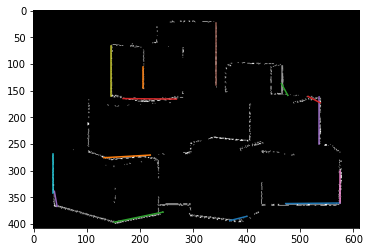

In [189]:
from matplotlib import pyplot as plt
from scipy import ndimage
datadir = './data'
i = 0

for img_path in glob.glob(datadir+'/*.jpg'):
        # load grayscale image
    img = Image.open(img_path).convert("L")
    Igs = np.array(img.copy())
    Igs = Igs / 255.
        
    Im, Io, Ix, Iy = EdgeDetection(Igs, sigma, highThreshold, lowThreshold)
    H = HoughTransform(Im, rhoRes, thetaRes)
    lRho,lTheta =HoughLines(H,rhoRes,thetaRes,nLines)
    I = HoughLineSegments(lRho, lTheta, Im)
        
    plt.figure()
    plt.imshow(Im,cmap='gray')
    plt.axis('on')
    for i in range(len(I)):
        plt.plot([I[i]['start'][1],I[i]['end'][1]],[I[i]['start'][0],I[i]['end'][0]])
    plt.show()
    i =+1
    if (i == 1): 
        break

In [ ]:
def main():

    # read images
    for img_path in glob.glob(datadir+'/*.jpg'):
        # load grayscale image
        img = Image.open(img_path).convert("L")

        Igs = np.array(img)
        Igs = Igs / 255.

        # Hough function
        Im, Io, Ix, Iy = EdgeDetection(Igs, sigma, highThreshold, lowThreshold)
        H= HoughTransform(Im, rhoRes, thetaRes)
        lRho,lTheta =HoughLines(H,rhoRes,thetaRes,nLines)
        l = HoughLineSegments(lRho, lTheta, Im)

        # saves the outputs to files
        # Im, H, Im + hough line , Im + hough line segments


if __name__ == '__main__':
    main()

In [114]:
a = np.array([[1,2,3,4,5],[2,3,4,5,6],[6,5,4,3,2],[1,4,3,5,2],[3,4,5,6,4],[23,3,32,3,3]])
nonzero = np.transpose(np.nonzero(a))
th =2
h,w = a.shape

for nz in nonzero:
        U = nz[0]-th
        D = nz[0]+th+1
        L = nz[1]-th
        R = nz[1]+th+1
        if (nz[0]<th): 
            U = 0
        if (nz[0]>=h-th):
            D = h
        if (nz[1]<th):
            L = 0
        if (nz[1]>=w-th):
            print(nz,list(range(0,R-w,1)))
            R = w
        
        if (np.any(a[U:D,L:R]>a[nz[0],nz[1]])):
            a[nz[0],nz[1]] = 0
print(a)



[0 3] [0]
[0 4] [0, 1]
[1 3] [0]
[1 4] [0, 1]
[2 3] [0]
[2 4] [0, 1]
[3 3] [0]
[3 4] [0, 1]
[4 3] [0]
[4 4] [0, 1]
[5 3] [0]
[5 4] [0, 1]
[[ 0  0  0  0  0]
 [ 0  0  0  0  6]
 [ 6  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 32  0  0]]


In [170]:
a = np.array([[1,2,3,4,5],[2,3,4,5,6],[6,5,4,3,2],[1,4,3,5,2],[3,4,5,6,4],[23,3,32,3,3]])
a[[0,1,2].del(1),[1,2,3]]

SyntaxError: invalid syntax (<ipython-input-170-98b70b808c2c>, line 2)

In [177]:
b = list({1,2,3})
del b[1]
b

[1, 3]